In [18]:
#imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, log_loss
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import pickle

In [19]:
call = pd.read_csv("data/Train_call.txt", sep='\t')
clin = pd.read_csv("data/Train_clinical.txt", sep='\t')


X=call[clin[clin['Subgroup']!='HER2+']['Sample']].T

X
#X.shape

,0,1,2,3,4,5,6,7,8,9,...,2824,2825,2826,2827,2828,2829,2830,2831,2832,2833
Array.34,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
Array.67,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
Array.24,0,0,0,0,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
Array.22,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
Array.36,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Array.35,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
Array.93,0,0,1,1,1,1,1,1,0,0,...,1,1,1,1,1,1,1,1,1,1
Array.123,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
Array.100,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [20]:
y = clin[clin['Subgroup']!='HER2+'].set_index('Sample')['Subgroup']

y

Sample
Array.34            HR+
Array.67            HR+
Array.24     Triple Neg
Array.22     Triple Neg
Array.36            HR+
                ...    
Array.35            HR+
Array.93     Triple Neg
Array.123           HR+
Array.100           HR+
Array.134           HR+
Name: Subgroup, Length: 68, dtype: object

In [21]:
folds_file = 'data/folds.pickle'
with open(folds_file, 'rb') as fid:
    outer_cross_val = pickle.load(fid)

# Baseline
Running xgboost on all regions. We reduce depth of trees in xgboost to make sure we get the simplest model since we have almost no data.

In [22]:
def get_data_sets(X_set):
    X_train_list, y_train_list = [], []
    X_val_list, y_val_list = [], []

    for split in outer_cross_val:
        inner_cross_val, test_index = split
        for train_index, val_index in inner_cross_val:
            X_train, y_train = X.iloc[train_index,:], y[train_index]
            X_val, y_val = X.iloc[val_index,:], y[val_index]

            X_train_list.append(X_train)
            y_train_list.append(y_train)

            X_val_list.append(X_val)
            y_val_list.append(y_val)
    return X_train_list, y_train_list, X_val_list, y_val_list

In [23]:
accuracy_list = []
av_logloss_list = []
def get_XGB_results(X_set):
    X_train_list, y_train_list, X_val_list, y_val_list = get_data_sets(X_set)

    for (X_train, y_train, X_val, y_val) in zip(X_train_list, y_train_list, X_val_list, y_val_list):
        model = XGBClassifier(max_depth=1, objective='binary:logistic', random_state=12345)
        model.fit(X_train, y_train=='HR+')

        y_pred = model.predict(X_val)
        predictions = [round(value) for value in y_pred]
        accuracy = accuracy_score(y_val=='HR+', predictions)
        av_logloss = log_loss(y_true=y_val=='HR+',labels=[True,False], y_pred=y_pred)

        accuracy_list.append(accuracy)
        av_logloss_list.append(av_logloss)

    print(np.mean(accuracy_list),np.std(accuracy_list))
    print(np.mean(av_logloss_list),np.std(av_logloss_list))


In [24]:
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import seaborn as sns

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
    "Logistic Regression",
    "XGBoost",
    "Light Gradient Boosting Machine",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, probability=True,random_state=12345),
    SVC(gamma=2, C=1, probability=True,random_state=12345),
    GaussianProcessClassifier(1.0 * RBF(1.0),random_state=12345),
    DecisionTreeClassifier(max_depth=5,random_state=12345),
    RandomForestClassifier(random_state=12345),
    AdaBoostClassifier(random_state=12345),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(penalty = 'elasticnet',solver='saga',
                       l1_ratio=0.5, max_iter=10000,random_state=12345),
    XGBClassifier(max_depth=1, objective='binary:logistic', random_state=12345),
    LGBMClassifier(random_state=12345)
]

scores_acc = pd.DataFrame()
scores_logloss = pd.DataFrame()

def model_results(X_set,name,model):
    X_train_list, y_train_list, X_val_list, y_val_list = get_data_sets(X_set)

    accuracy_list = []
    av_logloss_list = []

    for (X_train, y_train, X_val, y_val) in zip(X_train_list, y_train_list, X_val_list, y_val_list):
        model.fit(X_train, np.float32(y_train=='HR+'))

        y_pred = model.predict_proba(X_val)[:,1]
        predictions = [round(value) for value in y_pred]
        accuracy = accuracy_score(y_val=='HR+', predictions)
        av_logloss = log_loss(y_true=y_val=='HR+',labels=[True,False], y_pred=y_pred)

        accuracy_list.append(accuracy)
        av_logloss_list.append(av_logloss)
    scores_acc[name] = accuracy_list
    scores_logloss[name] = av_logloss_list
    print('Results for {} model'.format(name))
    print('Accuracy mean: {}, std: {}'.format(np.mean(accuracy_list),np.std(accuracy_list)))
    print('Logloss mean: {}, std: {}'.format(np.mean(av_logloss_list),np.std(av_logloss_list)))



def get_all_results(feature_method,X_set):
    for name, model in zip(names,classifiers):
        model_results(X_set,name,model)

    # Compare score
    fig, ax = plt.subplots(figsize=(20,3))
    _ = sns.pointplot(data=scores_acc, ci='sd', join=False,
                  ax=ax)
    _ = ax.set_xlabel('')
    _ = ax.set_ylabel('cv accuracy', fontsize=14)
    _ = ax.tick_params(labelsize=10)
    plt.savefig(f"{feature_method} cv accuracy.png", dpi=300)
    plt.show()
    plt.close()

    fig, ax = plt.subplots(figsize=(20,3))
    _ = sns.pointplot(data=scores_logloss, ci='sd', join=False,
                  ax=ax)
    _ = ax.set_xlabel('')
    _ = ax.set_ylabel('cv logloss', fontsize=14)
    _ = ax.tick_params(labelsize=10)
    plt.savefig(f"{feature_method} cv logloss'.png", dpi=300)
    plt.show()
    plt.close()


0.7738095238095238 0.16566022654094245
7.8124346142663805 5.7217719395691535
Results for Nearest Neighbors model
Accuracy mean: 0.5407142857142858, std: 0.16957646988400837
Logloss mean: 2.2551650836455184, std: 2.756644564437343
Results for Linear SVM model
Accuracy mean: 0.7654761904761905, std: 0.15809147299016335
Logloss mean: 0.515593782658724, std: 0.2007826672743359
Results for RBF SVM model
Accuracy mean: 0.35857142857142854, std: 0.12758972655349435
Logloss mean: 0.7063883309464566, std: 0.020909872796553864
Results for Gaussian Process model
Accuracy mean: 0.4895238095238096, std: 0.19018787703591566
Logloss mean: 0.6931471807694624, std: 3.803630821804636e-09
Results for Decision Tree model
Accuracy mean: 0.606904761904762, std: 0.18171814785752954
Logloss mean: 12.602155016257095, std: 6.126161165962228
Results for Random Forest model
Accuracy mean: 0.7511904761904763, std: 0.17004651224453451
Logloss mean: 0.5553712935031617, std: 0.09627498167113191
Results for AdaBoost m

D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github 

Results for QDA model
Accuracy mean: 0.48619047619047623, std: 0.18645092002516717
Logloss mean: 17.74652321397847, std: 6.439876665056914
Results for Logistic Regression model
Accuracy mean: 0.8321428571428572, std: 0.151873224073489
Logloss mean: 0.3987722794720128, std: 0.22934383152959553
Results for XGBoost model
Accuracy mean: 0.7738095238095238, std: 0.16566022654094245
Logloss mean: 0.5308816787381823, std: 0.2994168117777798
Results for Light Gradient Boosting Machine model
Accuracy mean: 0.6, std: 0.19549924462392707
Logloss mean: 0.6855461532210235, std: 0.20802877382448715


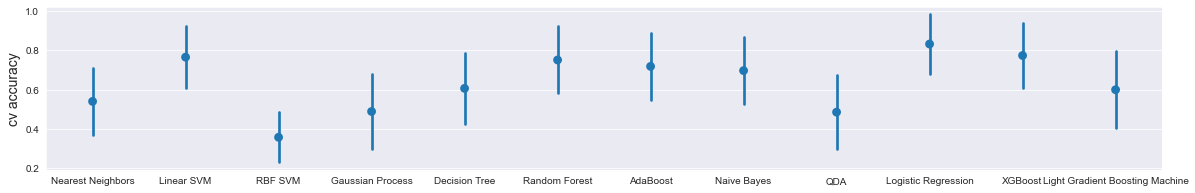

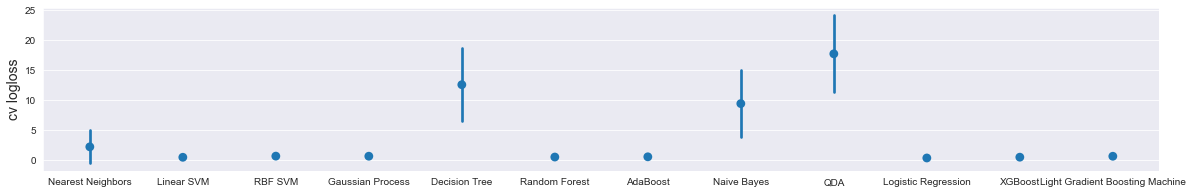

In [25]:
get_XGB_results(X)
get_all_results('Baseline',X)

# Feature selection

In [26]:
selected_features = {}

##  Variance Threshold


In [27]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.9) # Variance threshold
sel = selector.fit(X)
sel_index = sel.get_support()
norm_vt = X.iloc[:, sel_index]
coloms = norm_vt.columns.tolist()
print(coloms)
selected_features[ "VarianceThreshold"] = coloms

[192, 1086, 1087, 1092, 1604]


##  Chi-square test

In [28]:
from numpy import array
import sklearn
#导入sklearn库中的SelectKBest和chi2
from sklearn.feature_selection import SelectKBest ,chi2

X_transform = sklearn.preprocessing.MinMaxScaler().fit_transform(X)
#选择相关性最高的前5个特征
select = SelectKBest(chi2, k=5)
X_chi2 = select.fit_transform(X_transform, y)

filter = select.get_support()
features = array(X.columns.values)

s_f = features[filter].tolist()
print(s_f)
selected_features['Chi'] = s_f

[694, 695, 818, 1973, 2026]


## ANOVA F-value

1678 25.608978855596753
1656 24.15932773109244
1672 22.208512353629402
1679 21.26248942530032
1668 21.151580616618595
1667 21.151580616618595
1677 21.137254901960787
1664 20.796553016110902
1674 20.63277952402335
694 20.383816875166357
[1678, 1656, 1672, 1679, 1668, 1667, 1677, 1664, 1674, 694]


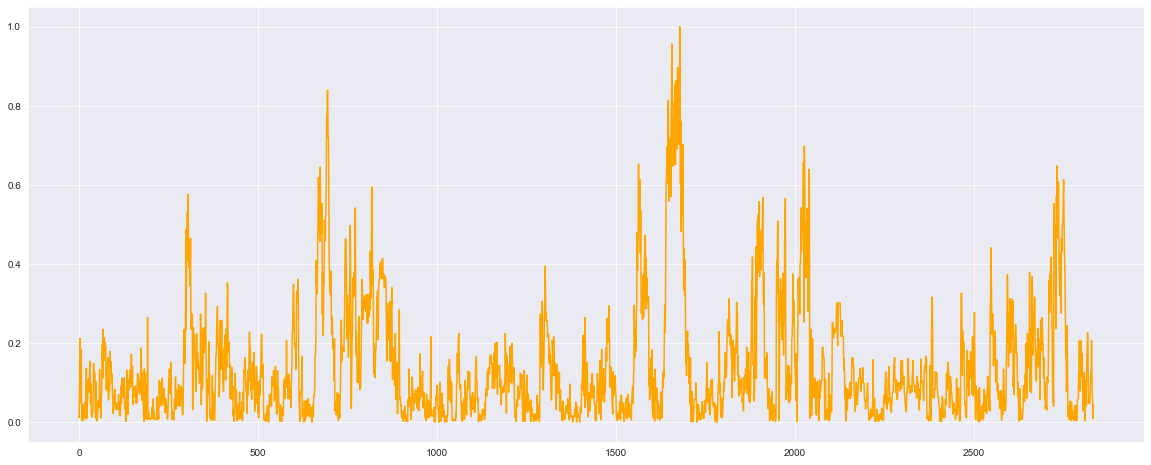

In [29]:
from sklearn.feature_selection import SelectPercentile, f_classif

threshold = 10 # the number of most relevant features
high_score_features = []
F,p = f_classif(X, y)
for score, f_name in sorted(zip(F, X.columns), reverse=True)[:threshold]:
      print(f_name, score)
      high_score_features.append(f_name)

print(high_score_features)
selected_features['ANOVA'] = high_score_features

plt.figure(figsize = (20,8))
X_indices = np.arange(X.shape[-1])
selector = SelectPercentile(f_classif, percentile=5)
selector.fit(X, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.plot(X_indices - .45, scores,
        label=r'Univariate score ($-Log(p_{value})$)', color='orange')


## Mutual information

In [30]:
from sklearn.feature_selection import mutual_info_classif
threshold = 5  # the number of most relevant features
high_score_features = []
feature_scores = mutual_info_classif(X, y, random_state=0)
for score, f_name in sorted(zip(feature_scores, X.columns), reverse=True)[:threshold]:
        print(f_name, score)
        high_score_features.append(f_name)
norm_mic = X[high_score_features]
print(norm_mic.columns)
selected_features['MutualInfo'] = norm_mic.columns.tolist()

1679 0.27488031926298917
2748 0.27055519177609666
1660 0.26119317051107527
1656 0.25873844859040895
2751 0.2415170730320959
Int64Index([1679, 2748, 1660, 1656, 2751], dtype='int64')


## Embedded Methods

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
model_lr = LogisticRegression(random_state=0, C=0.01)
model_rf = RandomForestClassifier(n_estimators=500, random_state=0, max_depth = 3)
model_lr.fit(X, y)
#model_rf.fit(df_wine_norm_features, df_wine_target)
sel_sfm = SelectFromModel(model_lr, prefit=True, max_features=5)
print(sel_sfm)
sel_sfm_index = sel_sfm.get_support()
norm_sfm = X.iloc[:, sel_sfm_index]
print(norm_sfm.columns)
selected_features['Embedded'] = norm_sfm.columns.tolist()

SelectFromModel(estimator=LogisticRegression(C=0.01, random_state=0),
                max_features=5, prefit=True)
Int64Index([192, 2017, 2023, 2024, 2026], dtype='int64')


## Wrapper Methods

In [32]:
from sklearn.feature_selection import RFE
threshold = 5# 最相关特征的数量
model_rf = RandomForestClassifier(n_estimators=500,random_state=0, max_depth = 3)
#model_lr = LogisticRegression(random_state=0, C=0.01)
selector = RFE(model_rf , n_features_to_select=threshold, step=1)
selector = selector.fit(X, y)
selector_ind = selector.get_support()
norm_rfe = X.iloc[:, selector_ind]
print(norm_rfe.columns)
selected_features['RF'] = norm_rfe.columns.tolist()

Int64Index([743, 1656, 1678, 2732, 2751], dtype='int64')


In [33]:
print(selected_features)

{'VarianceThreshold': [192, 1086, 1087, 1092, 1604], 'Chi': [694, 695, 818, 1973, 2026], 'ANOVA': [1678, 1656, 1672, 1679, 1668, 1667, 1677, 1664, 1674, 694], 'MutualInfo': [1679, 2748, 1660, 1656, 2751], 'Embedded': [192, 2017, 2023, 2024, 2026], 'RF': [743, 1656, 1678, 2732, 2751]}


VarianceThreshold
[192, 1086, 1087, 1092, 1604]
0.7738095238095238 0.16566022654094245
7.8124346142663805 5.7217719395691535

Results for Nearest Neighbors model
Accuracy mean: 0.5407142857142858, std: 0.16957646988400837
Logloss mean: 2.2551650836455184, std: 2.756644564437343
Results for Linear SVM model
Accuracy mean: 0.7654761904761905, std: 0.15809147299016335
Logloss mean: 0.515593782658724, std: 0.2007826672743359
Results for RBF SVM model
Accuracy mean: 0.35857142857142854, std: 0.12758972655349435
Logloss mean: 0.7063883309464566, std: 0.020909872796553864
Results for Gaussian Process model
Accuracy mean: 0.4895238095238096, std: 0.19018787703591566
Logloss mean: 0.6931471807694624, std: 3.803630821804636e-09
Results for Decision Tree model
Accuracy mean: 0.606904761904762, std: 0.18171814785752954
Logloss mean: 12.602155016257095, std: 6.126161165962228
Results for Random Forest model
Accuracy mean: 0.7511904761904763, std: 0.17004651224453451
Logloss mean: 0.5553712935031617

D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github 

Results for QDA model
Accuracy mean: 0.48619047619047623, std: 0.18645092002516717
Logloss mean: 17.74652321397847, std: 6.439876665056914
Results for Logistic Regression model
Accuracy mean: 0.8321428571428572, std: 0.151873224073489
Logloss mean: 0.3987722794720128, std: 0.22934383152959553
Results for XGBoost model
Accuracy mean: 0.7738095238095238, std: 0.16566022654094245
Logloss mean: 0.5308816787381823, std: 0.2994168117777798
Results for Light Gradient Boosting Machine model
Accuracy mean: 0.6, std: 0.19549924462392707
Logloss mean: 0.6855461532210235, std: 0.20802877382448715


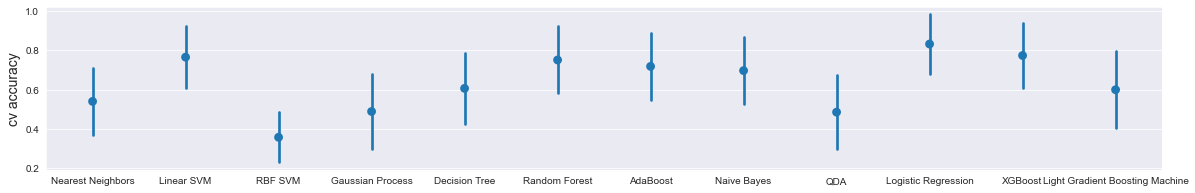

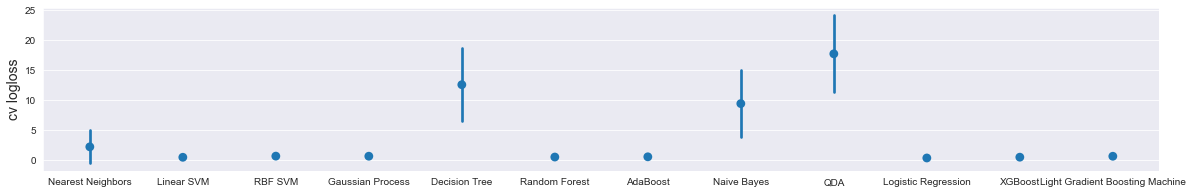

Chi
[694, 695, 818, 1973, 2026]
0.7738095238095238 0.16566022654094245
7.8124346142663805 5.7217719395691535

Results for Nearest Neighbors model
Accuracy mean: 0.5407142857142858, std: 0.16957646988400837
Logloss mean: 2.2551650836455184, std: 2.756644564437343
Results for Linear SVM model
Accuracy mean: 0.7654761904761905, std: 0.15809147299016335
Logloss mean: 0.515593782658724, std: 0.2007826672743359
Results for RBF SVM model
Accuracy mean: 0.35857142857142854, std: 0.12758972655349435
Logloss mean: 0.7063883309464566, std: 0.020909872796553864
Results for Gaussian Process model
Accuracy mean: 0.4895238095238096, std: 0.19018787703591566
Logloss mean: 0.6931471807694624, std: 3.803630821804636e-09
Results for Decision Tree model
Accuracy mean: 0.606904761904762, std: 0.18171814785752954
Logloss mean: 12.602155016257095, std: 6.126161165962228
Results for Random Forest model
Accuracy mean: 0.7511904761904763, std: 0.17004651224453451
Logloss mean: 0.5553712935031617, std: 0.0962749

D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github 

Results for QDA model
Accuracy mean: 0.48619047619047623, std: 0.18645092002516717
Logloss mean: 17.74652321397847, std: 6.439876665056914
Results for Logistic Regression model
Accuracy mean: 0.8321428571428572, std: 0.151873224073489
Logloss mean: 0.3987722794720128, std: 0.22934383152959553
Results for XGBoost model
Accuracy mean: 0.7738095238095238, std: 0.16566022654094245
Logloss mean: 0.5308816787381823, std: 0.2994168117777798
Results for Light Gradient Boosting Machine model
Accuracy mean: 0.6, std: 0.19549924462392707
Logloss mean: 0.6855461532210235, std: 0.20802877382448715


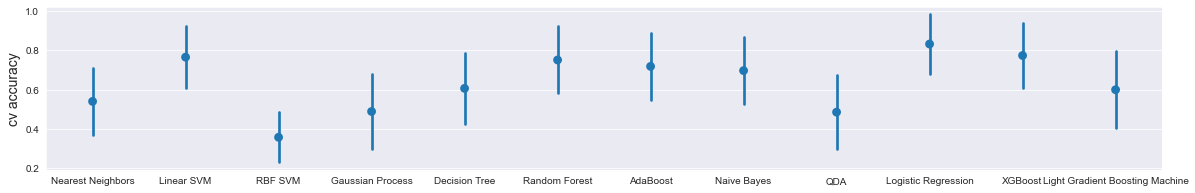

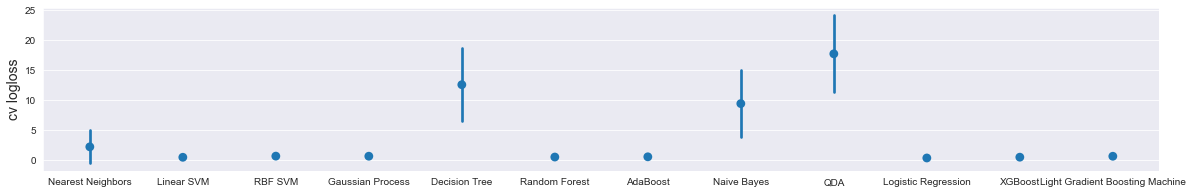

ANOVA
[1678, 1656, 1672, 1679, 1668, 1667, 1677, 1664, 1674, 694]
0.7738095238095238 0.16566022654094245
7.8124346142663805 5.7217719395691535

Results for Nearest Neighbors model
Accuracy mean: 0.5407142857142858, std: 0.16957646988400837
Logloss mean: 2.2551650836455184, std: 2.756644564437343
Results for Linear SVM model
Accuracy mean: 0.7654761904761905, std: 0.15809147299016335
Logloss mean: 0.515593782658724, std: 0.2007826672743359
Results for RBF SVM model
Accuracy mean: 0.35857142857142854, std: 0.12758972655349435
Logloss mean: 0.7063883309464566, std: 0.020909872796553864
Results for Gaussian Process model
Accuracy mean: 0.4895238095238096, std: 0.19018787703591566
Logloss mean: 0.6931471807694624, std: 3.803630821804636e-09
Results for Decision Tree model
Accuracy mean: 0.606904761904762, std: 0.18171814785752954
Logloss mean: 12.602155016257095, std: 6.126161165962228
Results for Random Forest model
Accuracy mean: 0.7511904761904763, std: 0.17004651224453451
Logloss mean: 

D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github 

Results for QDA model
Accuracy mean: 0.48619047619047623, std: 0.18645092002516717
Logloss mean: 17.74652321397847, std: 6.439876665056914
Results for Logistic Regression model
Accuracy mean: 0.8321428571428572, std: 0.151873224073489
Logloss mean: 0.3987722794720128, std: 0.22934383152959553
Results for XGBoost model
Accuracy mean: 0.7738095238095238, std: 0.16566022654094245
Logloss mean: 0.5308816787381823, std: 0.2994168117777798
Results for Light Gradient Boosting Machine model
Accuracy mean: 0.6, std: 0.19549924462392707
Logloss mean: 0.6855461532210235, std: 0.20802877382448715


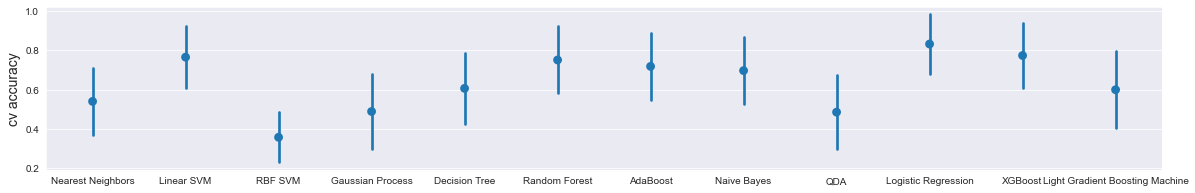

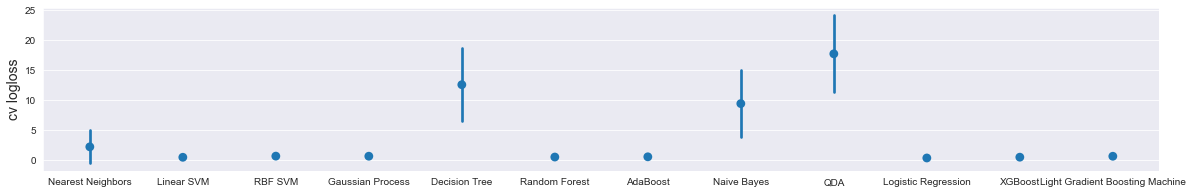

MutualInfo
[1679, 2748, 1660, 1656, 2751]
0.7738095238095238 0.16566022654094245
7.812434614266379 5.7217719395691535

Results for Nearest Neighbors model
Accuracy mean: 0.5407142857142858, std: 0.16957646988400837
Logloss mean: 2.2551650836455184, std: 2.756644564437343
Results for Linear SVM model
Accuracy mean: 0.7654761904761905, std: 0.15809147299016335
Logloss mean: 0.515593782658724, std: 0.2007826672743359
Results for RBF SVM model
Accuracy mean: 0.35857142857142854, std: 0.12758972655349435
Logloss mean: 0.7063883309464566, std: 0.020909872796553864
Results for Gaussian Process model
Accuracy mean: 0.4895238095238096, std: 0.19018787703591566
Logloss mean: 0.6931471807694624, std: 3.803630821804636e-09
Results for Decision Tree model
Accuracy mean: 0.606904761904762, std: 0.18171814785752954
Logloss mean: 12.602155016257095, std: 6.126161165962228
Results for Random Forest model
Accuracy mean: 0.7511904761904763, std: 0.17004651224453451
Logloss mean: 0.5553712935031617, std: 

D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github 

Results for QDA model
Accuracy mean: 0.48619047619047623, std: 0.18645092002516717
Logloss mean: 17.74652321397847, std: 6.439876665056914
Results for Logistic Regression model
Accuracy mean: 0.8321428571428572, std: 0.151873224073489
Logloss mean: 0.3987722794720128, std: 0.22934383152959553
Results for XGBoost model
Accuracy mean: 0.7738095238095238, std: 0.16566022654094245
Logloss mean: 0.5308816787381823, std: 0.2994168117777798
Results for Light Gradient Boosting Machine model
Accuracy mean: 0.6, std: 0.19549924462392707
Logloss mean: 0.6855461532210235, std: 0.20802877382448715


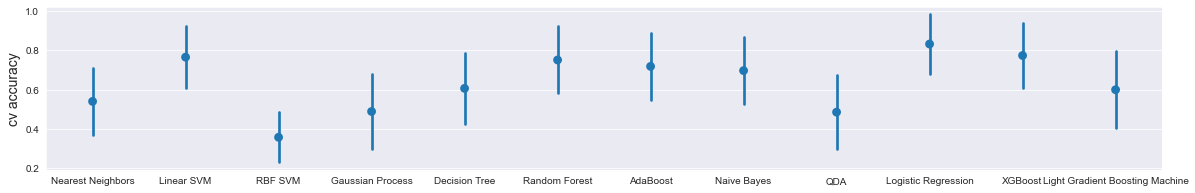

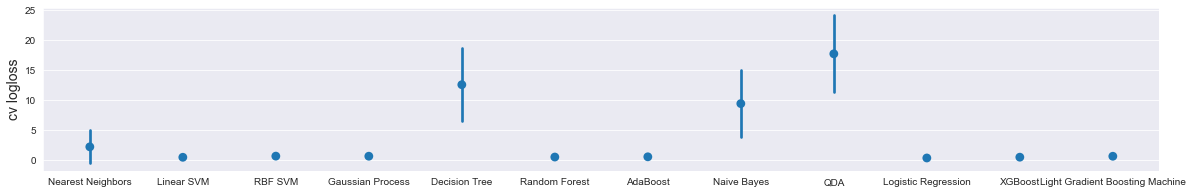

Embedded
[192, 2017, 2023, 2024, 2026]
0.7738095238095238 0.16566022654094245
7.81243461426638 5.7217719395691535

Results for Nearest Neighbors model
Accuracy mean: 0.5407142857142858, std: 0.16957646988400837
Logloss mean: 2.2551650836455184, std: 2.756644564437343
Results for Linear SVM model
Accuracy mean: 0.7654761904761905, std: 0.15809147299016335
Logloss mean: 0.515593782658724, std: 0.2007826672743359
Results for RBF SVM model
Accuracy mean: 0.35857142857142854, std: 0.12758972655349435
Logloss mean: 0.7063883309464566, std: 0.020909872796553864
Results for Gaussian Process model
Accuracy mean: 0.4895238095238096, std: 0.19018787703591566
Logloss mean: 0.6931471807694624, std: 3.803630821804636e-09
Results for Decision Tree model
Accuracy mean: 0.606904761904762, std: 0.18171814785752954
Logloss mean: 12.602155016257095, std: 6.126161165962228
Results for Random Forest model
Accuracy mean: 0.7511904761904763, std: 0.17004651224453451
Logloss mean: 0.5553712935031617, std: 0.09

D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github 

Results for QDA model
Accuracy mean: 0.48619047619047623, std: 0.18645092002516717
Logloss mean: 17.74652321397847, std: 6.439876665056914
Results for Logistic Regression model
Accuracy mean: 0.8321428571428572, std: 0.151873224073489
Logloss mean: 0.3987722794720128, std: 0.22934383152959553
Results for XGBoost model
Accuracy mean: 0.7738095238095238, std: 0.16566022654094245
Logloss mean: 0.5308816787381823, std: 0.2994168117777798
Results for Light Gradient Boosting Machine model
Accuracy mean: 0.6, std: 0.19549924462392707
Logloss mean: 0.6855461532210235, std: 0.20802877382448715


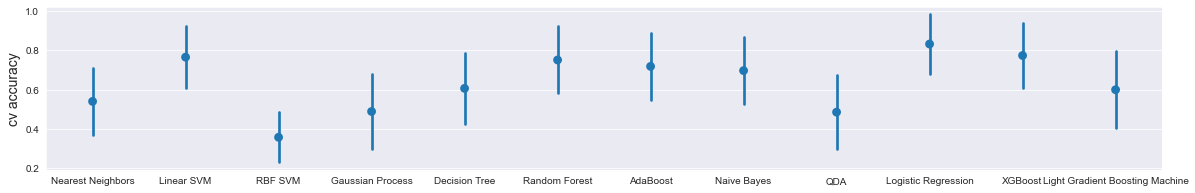

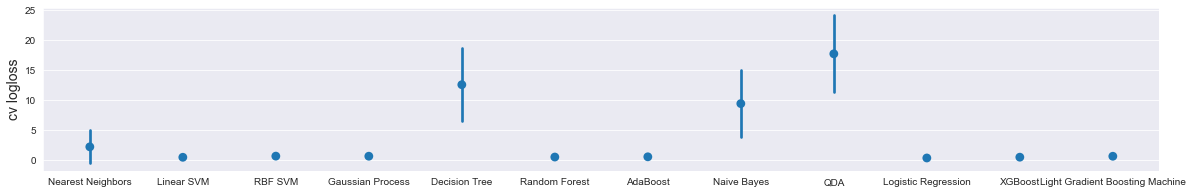

RF
[743, 1656, 1678, 2732, 2751]
0.773809523809524 0.16566022654094245
7.8124346142663805 5.7217719395691535

Results for Nearest Neighbors model
Accuracy mean: 0.5407142857142858, std: 0.16957646988400837
Logloss mean: 2.2551650836455184, std: 2.756644564437343
Results for Linear SVM model
Accuracy mean: 0.7654761904761905, std: 0.15809147299016335
Logloss mean: 0.515593782658724, std: 0.2007826672743359
Results for RBF SVM model
Accuracy mean: 0.35857142857142854, std: 0.12758972655349435
Logloss mean: 0.7063883309464566, std: 0.020909872796553864
Results for Gaussian Process model
Accuracy mean: 0.4895238095238096, std: 0.19018787703591566
Logloss mean: 0.6931471807694624, std: 3.803630821804636e-09
Results for Decision Tree model
Accuracy mean: 0.606904761904762, std: 0.18171814785752954
Logloss mean: 12.602155016257095, std: 6.126161165962228
Results for Random Forest model
Accuracy mean: 0.7511904761904763, std: 0.17004651224453451
Logloss mean: 0.5553712935031617, std: 0.0962749

D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github Projects\B4TM\venv\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\Github 

Results for QDA model
Accuracy mean: 0.48619047619047623, std: 0.18645092002516717
Logloss mean: 17.74652321397847, std: 6.439876665056914
Results for Logistic Regression model
Accuracy mean: 0.8321428571428572, std: 0.151873224073489
Logloss mean: 0.3987722794720128, std: 0.22934383152959553
Results for XGBoost model
Accuracy mean: 0.7738095238095238, std: 0.16566022654094245
Logloss mean: 0.5308816787381823, std: 0.2994168117777798
Results for Light Gradient Boosting Machine model
Accuracy mean: 0.6, std: 0.19549924462392707
Logloss mean: 0.6855461532210235, std: 0.20802877382448715


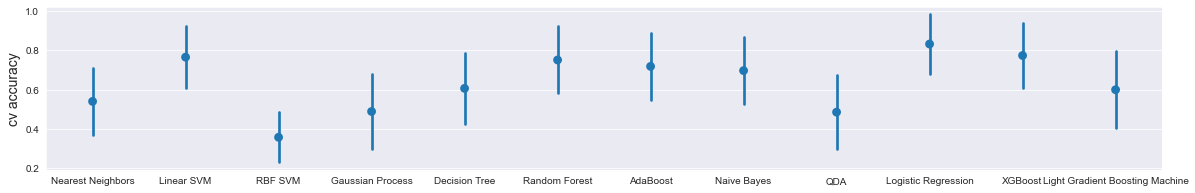

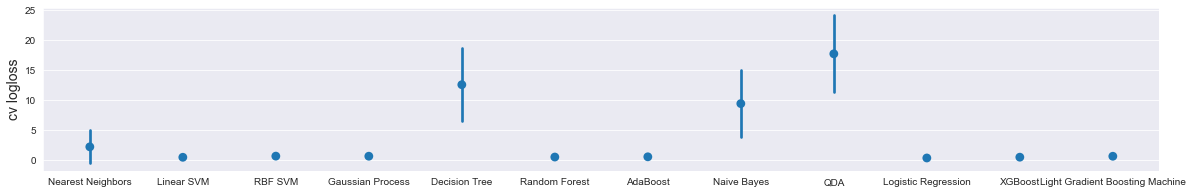

In [34]:
for k,v in selected_features.items():
    X_new = X[v]
    print(k)
    print(v)
    get_XGB_results(X_new)
    print()
    get_all_results(k,X_new)